# Decision analysis with `rdecision` using Evans, 1997 
Tomás Aragón, Updated 2026-01-27

I mostly replicated R `rdecision` vignette "Elementary decision tree (Evans 1997)": https://cran.r-project.org/web/packages/rdecision/vignettes/DT01-Sumatriptan.html . 

Sources:
- Briggs, Andrew Harvey, Karl Claxton, and Mark Sculpher. Decision Modelling for Health Economic Evaluation. Repr. [d. korr. Ausg. von 2007]. Handbooks in Health Economic Evaluation Series. Oxford Univ. Press, 2011.
- Evans, K. W., J. A. Boan, J. L. Evans, and A. Shuaib. “Economic Evaluation of Oral Sumatriptan Compared with Oral Caffeine/Ergotamine for Migraine.” PharmacoEconomics 12, no. 5 (1997): 565–77. https://doi.org/10.2165/00019053-199712050-00007.

This Jupyter R notebook was created in VS Code and contains examples from Evans, 1997 using R code.

If you are not already using R in VS Code, then use Positron from Posit (https://positron.posit.co/). Positron is a free IDE for data science designed to support Python and R (Julia works too). Positron is built on the same open-source foundation as Visual Studio Code (VS Code).   

We will use `rdecision` R package: https://cran.r-project.org/web/packages/rdecision/index.html

The `rdecision` CRAN page has links to several vignettes using health decision analysis examples.

Preparation:
- Review R `rdecision` vignette [Elementary decision tree (Evans 1997)](https://cran.r-project.org/web/packages/rdecision/vignettes/DT01-Sumatriptan.html)
- Review [Introduction to the construction of decision trees](https://cran.r-project.org/web/packages/rdecision/vignettes/DT00-DecisionTreeTutorial.html) from the `rdecision` package CRAN page.  
- Review previous `rdecision` [notebooks](https://github.com/tomasaragon/di4h) (highly recommended). 
- Read [Evans, 1997, article](https://github.com/tomasaragon/di4h/blob/main/files/Evans_1997_pmid_10174323.pdf) (optional). 

Optional readings for background:
- Owens, Douglas K. “Analytic Tools for Public Health Decision Making.” Medical Decision Making: An International Journal of the Society for Medical Decision Making 22, no. 5 Suppl (2002): S3-10. https://doi.org/10.1177/027298902237969.
- Owens, D. K., R. D. Shachter, and R. F. Nease. “Representation and Analysis of Medical Decision Problems with Influence Diagrams.” Medical Decision Making: An International Journal of the Society for Medical Decision Making 17, no. 3 (1997): 241–62. https://doi.org/10.1177/0272989X9701700301.
- Nease, R. F., and D. K. Owens. “Use of Influence Diagrams to Structure Medical Decisions.” Medical Decision Making: An International Journal of the Society for Medical Decision Making 17, no. 3 (1997): 263–75. https://doi.org/10.1177/0272989X9701700302.
- Neapolitan, Richard, Xia Jiang, Daniela P. Ladner, and Bruce Kaplan. “A Primer on Bayesian Decision Analysis With an Application to a Kidney Transplant Decision.” Transplantation 100, no. 3 (2016): 489–96. https://doi.org/10.1097/TP.0000000000001145.

## Using `rdecision` R package to draw Figure 2-1 from Petitti Chapter 2
A decision tree is equivalent to an influence diagram, and both have nodes and edges. 

Nodes are variables and include:
- **Decision** nodes (represented as squares)
- **Chance** nodes (represented as circles)
- **Leaf** nodes (also called terminal, utility, or value nodes)

Edges connect nodes and include:
- **Action** edges eminating from decision nodes
- **Reaction** edges eminating from chance nodes

In `rdecision`, here key functions and their arguments:
```r
DecisionNode$new(label = "")
ChanceNode$new(label = "")
LeafNode$new(label = "", utility = 0)
Action$new(source_node, target_node, label, cost = 0, benefit = 0) 
Reaction$new(source_node, target_node, p = 0, cost = 0, benefit = 0, label = "")
```

## Creating the model
"This vignette is an example of modelling a decision tree using the rdecision package. It is based on the example given by Briggs (Box 2.3) which itself is based on a decision tree which compared oral Sumatriptan versus oral caffeine/Ergotamine for migraine. In this vignette, we consider the problem from the perspective of a provincial health department."

<figure>
<img src="img_Briggs2006_Box2-3.png" width="700" alt="Evans 1997 Figure 1"/>
<figcaption>BOX 2.3. Decision tree from Briggs et al., 2006.</figcaption>
</figure>

### Figure 1 from Evans, 1997
Below is Figure 1 from Evans, 1997 article showing the decision tree structure. Figure 2 is the same decision tree but with annotations I added to make constructing the tree easier in R.

<figure>
<img src="img_evans1997_fig01.png" width="800" alt="Evans 1997 Figure 1"/>
<figcaption></figcaption>
</figure>

<figure>
<img src="img_evans1997_fig01.drawio_annotated.png" width="800" alt="Evans 1997 Figure 1"/>
<figcaption>FIGURE 2. Decision tree from Evans, 1997, Figure 1 with my annotations.</figcaption>
</figure>

### Model variables
The following code defines the variables for cost, utility and effect that will be used in the model. There are 14 variables in total; 4 costs, 4 utilities and 6 probabilities.

For clarity, I coded some of the variables differently than in the original vignette. For example,

`p_norecurrence_relief_sumatriptan = 0.594` $= P(\text{no recurrence} \mid \text{relief}, \text{sumatriptan})$.

For example, 

`p_endures_norelief = 0.92` $= P(\text{endures} \mid \text{no relief})$ applies to both sumatriptan and caffeine/ergotamine treatment arms, so this variable appears in both arms.

```r

In [13]:
library(rdecision)

In [14]:
# Time horizon
ths = as.difftime(24L, units = "hours")

# model variables for cost
c_sumatriptan = 16.10 #
c_caffeine = 1.32 #
c_ed = 63.16 #
c_hospital = 1093.0 #

# model variables for utility
u_relief_norecurrence = 1.0 # 
u_relief_recurrence = 0.9 #
u_norelief_endures = -0.30 #
u_norelief_ed = 0.1 #

# model variables for effect; p_norecurrence_relief_sumatriptan = P(no recurrence | relief, sumatriptan)
p_relief_sumatriptan = 0.558 # e03; # e04 use NA_real_ to indicate complement 
p_relief_caffeine = 0.379 # e05; # e06 use NA_real_ to indicate complement
p_norecurrence_relief_sumatriptan = 0.594 # e07; # e08 use NA_real_ to indicate complement
p_endures_norelief = 0.92 # e09, e13; # e10, e14 use NA_real_ to indicate complement
p_norecurrence_relief_caffeine = 0.703 # e11; # e12 use NA_real_ to indicate complement
p_relief_ed = .998 # e15, e17; # e16, e18 use NA_real_ to indicate complement

### Constructing the tree
"The following code constructs the decision tree. In the formulation used by rdecision, a decision tree is a form of arborescence, a directed graph of nodes and edges, with a single root and a unique path from the root to each leaf node. Decision trees comprise three types of node: decision, chance and leaf nodes and two types of edge: actions (whose sources are decision nodes) and reactions (whose sources are chance nodes), see Figure 1. If the probability of traversing one reaction edge from any chance node is set to `NA_real_`, it will be calculated as 1 minus the sum of probabilities of the other reaction edges from that node when the tree is evaluated."

In [15]:
# create all nodes first
## terminal nodes
ta = LeafNode$new("A", utility = u_relief_norecurrence, interval = ths)
tb = LeafNode$new("B", utility = u_relief_recurrence, interval = ths)
tc = LeafNode$new("C", utility = u_norelief_endures, interval = ths) 
td = LeafNode$new("D", utility = u_norelief_ed, interval = ths)
te = LeafNode$new("E", utility = u_norelief_endures, interval = ths)
tf = LeafNode$new("F", utility = u_relief_norecurrence, interval = ths)
tg = LeafNode$new("G", utility = u_relief_recurrence, interval = ths) 
th = LeafNode$new("H", utility = u_norelief_endures, interval = ths)
ti = LeafNode$new("I", utility = u_norelief_ed, interval = ths)
tj = LeafNode$new("J", utility = u_norelief_endures, interval = ths)


## chance nodes
c01 = ChanceNode$new("RELIEF (c01)")
c02 = ChanceNode$new("RELIEF (c02)")

c03 = ChanceNode$new("RECURRENCE (c03)")
c04 = ChanceNode$new("NO RELIEF (c04)")
c05 = ChanceNode$new("RECURRENCE (c05)")
c06 = ChanceNode$new("NO RELIEF (c06)")

c07 = ChanceNode$new("NO RELIEF (c07)")
c08 = ChanceNode$new("NO RELIEF (c08)")


## decision node
d01  = DecisionNode$new("Migraine => TREATMENT (d01)")

# create edges after nodes
## edges
e01 = Action$new(d01, c01, label = "Sumatriptan (e01)", cost = c_sumatriptan)
e02 = Action$new(d01, c02, label = "Caffeine/Ergot (e02)", cost = c_caffeine)

e03 = Reaction$new(c01, c03, p = p_relief_sumatriptan, label = "Relief (e03)")
e04 = Reaction$new(c01, c04, p = NA_real_, label = "No relief (e04)")
e05 = Reaction$new(c02, c05, p = p_relief_caffeine, label = "Relief (e05)")
e06 = Reaction$new(c02, c06, p = NA_real_, label = "No relief (e06)")

e07 = Reaction$new(c03, ta, p = p_norecurrence_relief_sumatriptan, label = "No recurrence (e07)")
e08 = Reaction$new(c03, tb, p = NA_real_, label = "Recurrence (e08)", cost = c_sumatriptan) # relieved with 2nd dose
e09 = Reaction$new(c04, tc, p = p_endures_norelief, label = "Endures attack (e09)")
e10 = Reaction$new(c04, c07, p = NA_real_, label = "Emergency Dept (e10)", cost = c_ed)
e11 = Reaction$new(c05, tf, p = p_norecurrence_relief_caffeine, label = "No recurrence (e11)")
e12 = Reaction$new(c05, tg, p = NA_real_, label = "Recurrence (e12)", cost = c_caffeine) # relieved with 2nd dose
e13 = Reaction$new(c06, th, p = p_endures_norelief, label = "Endures attack (e13)")
e14 = Reaction$new(c06, c08, p = NA_real_, label = "Emergency Dept (e14)", cost = c_ed)
e15 = Reaction$new(c07, td, p = p_relief_ed, label = "Relief (e15)")
e16 = Reaction$new(c07, te, p = NA_real_, label = "Hospitalization (e16)", cost = c_hospital)
e17 = Reaction$new(c08, ti, p = p_relief_ed, label = "Relief (e17)")
e18 = Reaction$new(c08, tj, p = NA_real_, label = "Hospitalization (e18)", cost = c_hospital)


# create lists of nodes (aka, vertices) and edges
V = list(
  d01,
  c01, c02, c03, c04, c05, c06, c07, c08, 
  ta, tb, tc, td, te, tf, tg, th, ti, tj
)
E = list(
  e01, e02, e03, e04, e05, e06, e07, e08, 
  e09, e10, e11, e12, e13, e14, e15, e16, 
  e17, e18
)

The code below is not rendering correctly in HTML. It should appear as a code block. 

```r
# tree 
dt = DecisionTree$new(V, E)  
dt$draw(border = TRUE) 
```

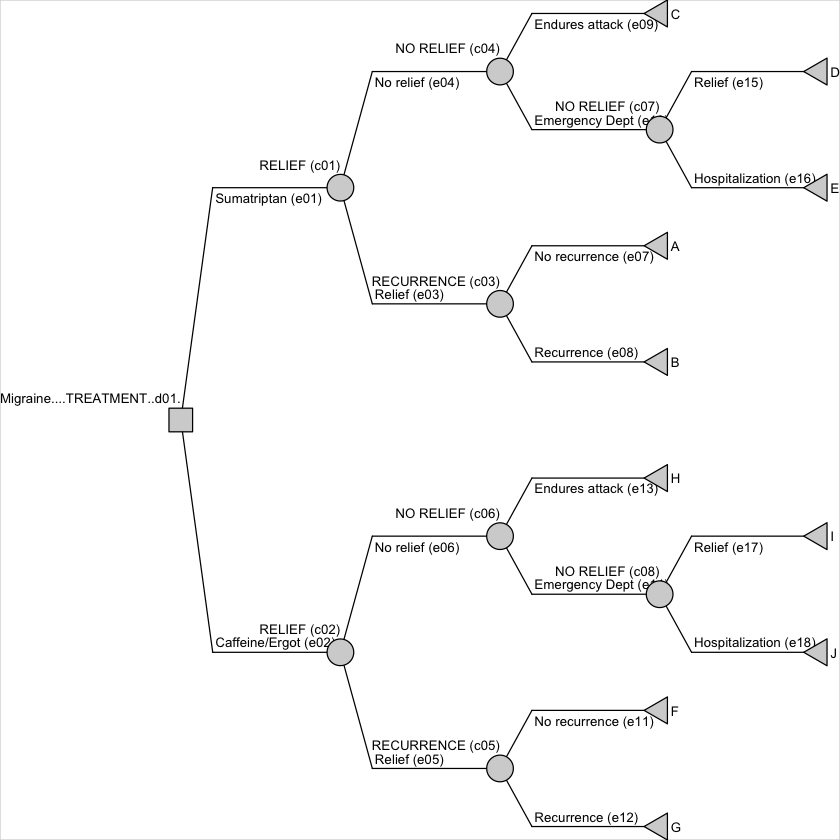

In [21]:
# tree 
dt = DecisionTree$new(V, E)  
dt$draw(border = TRUE) 

## Running the model
"The method evaluate of decision tree objects computes the probability, cost and utility of each strategy for the model. A strategy is a unanimous prescription of the actions at each decision node. In this example there is a single decision node with two actions, and the strategies are simply the two forms of treatment to be compared. More complex decision trees are also possible."

"The paths traversed in each strategy can be evaluated individually using the method evaluate(by = "path"). In rdecision a strategy is defined as a set of action edges with one action edge per decision node. It is necessary to use the option by = "path" only if information about each pathway is required; normally it is sufficient to call evaluate which will automatically aggregate the evaluation by strategy."

## Model results

### Base case 
The evaluation of each pathway, for each strategy, is done as follows and and yields the following table:

In [17]:
ep <- dt$evaluate(by = "path")
ep

Run,Migraine....TREATMENT..d01.,Leaf,Probability,Cost,Benefit,Utility,QALY
<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Caffeine/Ergot (e02),F,0.26643700,0.35169684,0,0.266437000,7.294648e-04
1,Caffeine/Ergot (e02),G,0.11256300,0.29716632,0,0.101306700,2.773626e-04
1,Caffeine/Ergot (e02),H,0.57132000,0.75414240,0,-0.171396000,-4.692567e-04
1,Caffeine/Ergot (e02),I,0.04958064,3.19695967,0,0.004958064,1.357444e-05
1,Caffeine/Ergot (e02),J,0.00009936,0.11500721,0,-0.000029808,-8.160986e-08
1,Sumatriptan (e01),A,0.33145200,5.33637720,0,0.331452000,9.074661e-04
1,Sumatriptan (e01),B,0.22654800,7.29484560,0,0.203893200,5.582292e-04
1,Sumatriptan (e01),C,0.40664000,6.54690400,0,-0.121992000,-3.339959e-04
1,Sumatriptan (e01),D,0.03528928,2.79702833,0,0.003528928,9.661678e-06


"There are, as expected, ten pathways (5 per strategy). The expected cost, utility and QALY (utility multiplied by the time horizon of the model) for each choice can be calculated from the table above, or by invoking the evaluate method of a decision tree object with the default parameter `by = "strategy"`." 

"This gives the following result, consistent with that reported by Evans et al."

In [18]:
es = dt$evaluate()
es

Run,Migraine....TREATMENT..d01.,Probability,Cost,Benefit,Utility,QALY
<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Caffeine/Ergot (e02),1,4.714972,0,0.2012760,0.0005510635
1,Sumatriptan (e01),1,22.058057,0,0.4168609,0.0011413030


The incremental cost was `$`Can 17.34 (22.06 - 4.71) and the incremental utility was 0.22 (0.42 - 0.2). Because the time horizon of the model was 1 day, the incremental QALYs was the incremental annual utility divided by 365, and the ICER was therefore equal to 29,383 `$`Can/QALY, within 5\% of the published estimate (29,366 `$`Can/QALY).

### Univariate sensitivity analysis -- PENDING


## Appendix
Plot of the decision tree (Figure 1 from Evans, 1997) using `rdecision` package.

<img src="img_rdecision_plot_of_evans1997_fig1.png" width="900" alt="Petitti 2000 Figure 2-6"/>